# IMPORTING LIBRARIES

##PROJECT PRESENTATION LINK:https://drive.google.com/file/d/16d_M_bHo5HN9YrKr2B01ZStcXBisqoJy/view?usp=sharing

In [ ]:
!pip install medmnist

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch
import torchvision
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import seaborn as sns
import medmnist
from medmnist import INFO, Evaluator

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

# IMPORTING DATASET FROM .NPZ(Online)

In [ ]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2023-01-26 04:52:26--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  15.9MB/s    in 1.2s    

2023-01-26 04:52:29 (15.9 MB/s) - ‘Data.npz’ saved [19725078/19725078]



In [ ]:
data = np.load('Data.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


## Checking the count of each train, test, and valid.

In [ ]:
print(f'Train Set:  X:%s Y:%s' %(data['train_images'].shape, data['train_labels'].shape))
print(f'Validation Set: X:%s Y:%s' %(data['val_images'].shape, data['val_labels'].shape))
print(f'Test Set :  X:%s Y:%s' %(data['test_images'].shape, data['test_labels'].shape))

Train Set:  X:(7007, 28, 28, 3) Y:(7007, 1)
Validation Set: X:(1003, 28, 28, 3) Y:(1003, 1)
Test Set :  X:(2005, 28, 28, 3) Y:(2005, 1)


In [ ]:
X_train = data['train_images']
X_val = data['val_images']
X_test = data['test_images']
X = np.concatenate((X_train, X_val, X_test), axis=0)

y_train = data['train_labels']
y_val = data['val_labels']
y_test = data['test_labels']
y = np.concatenate((y_train, y_val, y_test), axis=0)

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
data_flag = 'dermamnist'
download = True # If it is set to false, then data won't be downloaded.

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

  0%|          | 0/19725078 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 2005
    Root location: /roo

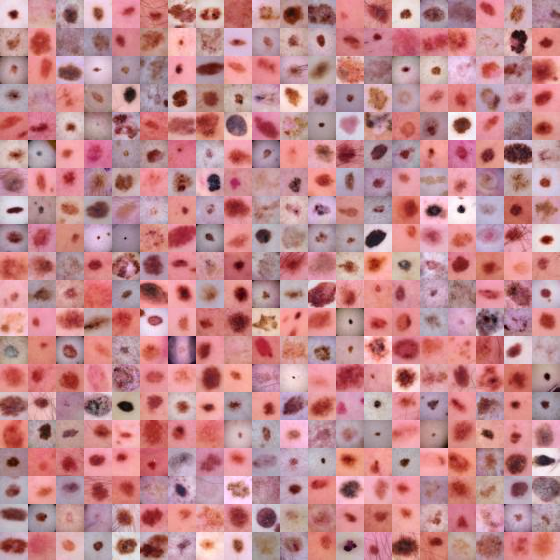

In [ ]:
train_dataset.montage(length=20)

*

## Labeling the columns

In [ ]:
labels = ['akiec','bcc','bkl','df','nv','vasc','mel']

In [ ]:
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
    'mel': 'Melanoma'
}

In [ ]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

## Numb of samples in Dataset

In [ ]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(y==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,327
bcc,514
bkl,1099
df,115
nv,1113
vasc,6705
mel,142


## Visualising Data

## Show off a few images in each category

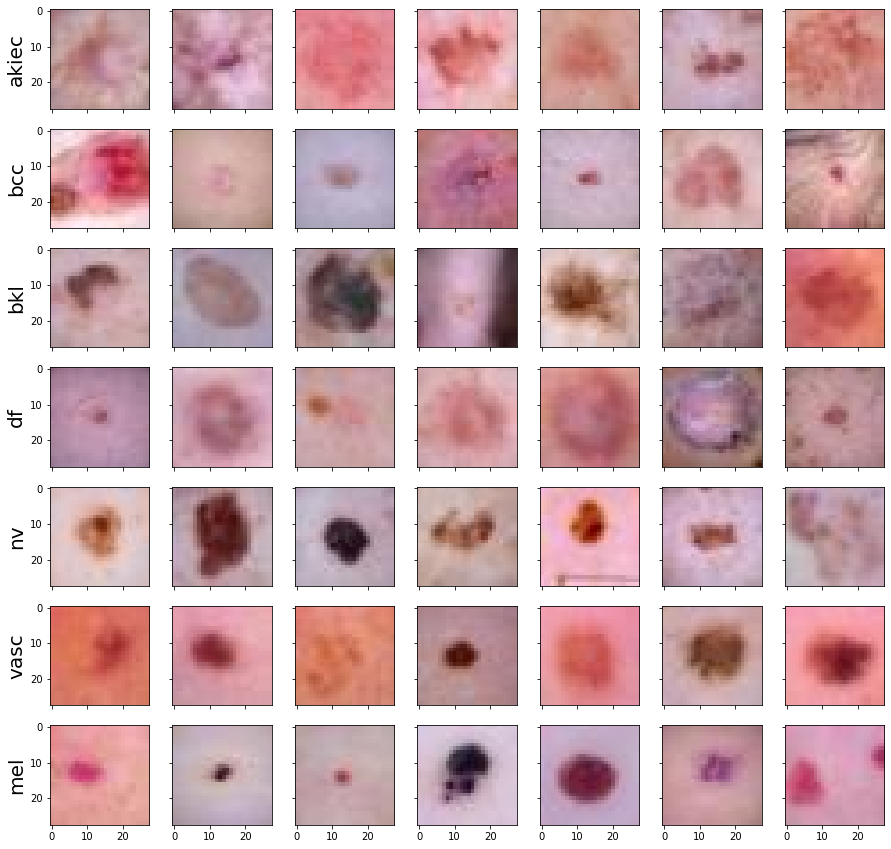

In [ ]:
fig, ax = plt.subplots(7, 7)
fig.set_figheight(15)
fig.set_figwidth(15)
for classes in range (7):
  for i, inx in enumerate(np.where(y==classes)[0][:7]):
    ax[classes,i].imshow(X[inx])
    ax[classes,i].set_ylabel(labels[classes],fontsize = 20.0)
    ax[classes,i].label_outer()

# Data Preprocessing

In [ ]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(y_train==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,228
bcc,359
bkl,769
df,80
nv,779
vasc,4693
mel,99


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
os_dict = {0: num_classes[0]*7,
           1: num_classes[1]*5,
           2: 1600,
           3: 3500,
           4: 1000,
           5: num_classes[5],
           6: 1600}
oversample = RandomOverSampler(sampling_strategy=os_dict)
oversampled_X , oversampled_y = oversample.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
print('Oversample_train_X:%s Oversample_train_y:%s' %(oversampled_X.shape, oversampled_y.shape))

Oversample_train_X:(15784, 2352) Oversample_train_y:(15784,)


In [ ]:
us_dict = {0: num_classes[0]*7,
           1: num_classes[1]*5,
           2: 1600,
           3: 3500,
           4: 1000,
           5: 3000,
           6: 1600}

undersample = RandomUnderSampler(sampling_strategy=us_dict)
undersampled_X , undersampled_y = undersample.fit_resample(oversampled_X, oversampled_y)
print('Undersample_X:%s Undersample_y:%s' %(undersampled_X.shape, undersampled_y.shape))

Undersample_X:(14091, 2352) Undersample_y:(14091,)


In [ ]:
undersampled_y.shape

(14091,)

In [ ]:
undersampled_X = undersampled_X.reshape(-1,28,28,3)

In [ ]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(undersampled_y==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,1596
bcc,1795
bkl,1600
df,3500
nv,1000
vasc,3000
mel,1600


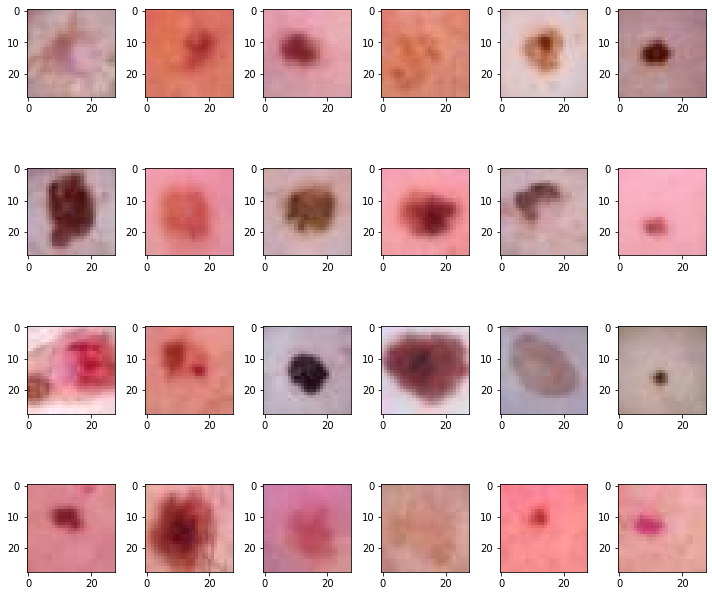

In [ ]:
f , ax = plt.subplots(4,6)
f.set_size_inches(10, 10)
k = 0 
for i in range(4):
    for j in range(6):
        ax[i,j].imshow(X_train[k].reshape(28,28,3))
        k = k + 1
    plt.tight_layout()

# network - 1 ephocs=3 , lr=0.01, sgd

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 32
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5,stride=1, padding=1)
        self.conv2 = nn.Conv2d(3,15, kernel_size=5,stride=1, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)#, momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

## train - 1

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

## test - 1

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

RuntimeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Evaluate

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# network - 2, ep=5

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network1 = Net()
optimizer1 = optim.SGD(network1.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
train_losses1 = []
train_counter1 = []
test_losses1 = []
test_counter1 = [i*len(train_loader.dataset) for i in range(n_epochs1 + 1)]

## train - 2

In [ ]:
def train(epoch):
  network1.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output1 = network1(data)
    loss1 = F.nll_loss(output1, target)
    loss1.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss1.item()))
      train_losses1.append(loss1.item())
      train_counter1.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

## test - 2

In [ ]:
def test():
  network1.eval()
  test_loss1 = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output1 = network(data)
      test_loss1 += F.nll_loss(output1, target, size_average=False).item()
      pred = output1.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss1 /= len(test_loader.dataset)
  test_losses.append(test_loss1)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss1, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs1 + 1):
  train(epoch)
  test()

## Evaluate

In [ ]:
fig = plt.figure()
plt.plot(train_counter1, train_losses1, color='blue')
plt.plot(test_counter1[:-1], test_losses1, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# network-3, ep=10,sgd

In [ ]:
n_epochs1 = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 32
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs1 + 1)]

## train

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
      train_losses1.append(loss.item())
      train_counter1.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

## test

In [ ]:
def test():
  network1.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

# network - 4, ephocs=3, adam

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 32
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)# momentum=momentum)

In [ ]:
train_losses= []
train_counter = []
test_losse = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

## train -3

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss2 = F.nll_loss(output, target)
    loss2.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss2.item()))
      train_losses.append(loss2.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

## test - 3

In [ ]:
def test():
  network.eval()
  test_loss2 = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss2 += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss2 /= len(test_loader.dataset)
  test_losses.append(test_loss2)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss2, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

# network -5, ,ep=5, adam


In [ ]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 28
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)# momentum=momentum)

In [ ]:
train_losses= []
train_counter = []
test_losse = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

## train4

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

## test 4

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

# network -6, ep=10,adam

In [ ]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 28
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)# momentum=momentum)

In [ ]:
train_losses= []
train_counter = []
test_losser = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

## train

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

## test

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()